# **Experiment Notebook**



In [16]:
# Align versions so pip stops warning
!pip install -q --upgrade "scikit-learn>=1.6" "umap-learn>=0.5.9" utstd

In [17]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [18]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [19]:
import os, sys, json, math, pathlib, warnings, datetime
from typing import List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
import joblib

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

---
## A. Project Description


In [20]:
# <Student to fill this section>
student_name = "Drashti Kakadiya"
student_id = "25414741"
group_id = "31"

In [21]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [22]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

In [23]:
# Do not modify this code
print_tile(size="h1", key='group_id', value=group_id)

---
## B. Business Understanding

In [24]:
# <Student to fill this section>
business_use_case_description = """
Goal: predict each player’s draft probability so the team can prioritise scouting/offers and allocate budget efficiently.
Impact: accurate → higher hit-rate, ROI, and wins; inaccurate → missed talent, wasted spend, weaker roster
"""

In [25]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [26]:
# <Student to fill this section>
business_objectives = """
Identify and rank high-potential draftees to focus scouting/offers, boosting draft hit-rate and roster quality.
Reduce wasted spend/time by filtering low-probability prospects, improving ROI and long-term team performance.
"""

In [27]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [28]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
Owners/GM: Clear ROI (higher draft hit-rate, lower scouting cost), on-time insights before draft windows, and defensible KPIs (AUROC, calibration).
Coaches: Short, trusted shortlists with thresholds and role-fit notes; minimal false positives that waste practice reps.
Scouting Dept: Augmentation (not replacement) of scouts; transparent feature importance and a feedback loop to correct misses.
Analytics/ML: Reproducible, leakage-free pipeline with versioned data, drift/quality monitoring, and easy what-if analyses.
Compliance/Legal: Fairness checks across demographics, privacy-safe data handling, and auditable decisions.
IT/Ops: Secure access, low-latency scoring API, uptime during peak draft activity, and smooth integration with existing tools.
"""


In [29]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [30]:
import pandas as pd
from pathlib import Path
from IPython.display import display

# Search in root and sample_data (works in Colab)
BASES = [Path("."), Path("sample_data"), Path("/content"), Path("/content/sample_data")]

def find_file(name, required=False):
    for b in BASES:
        p = (b / name).resolve()
        if p.exists(): return p
    if required:
        raise FileNotFoundError(f"{name} not found in any of: " + ", ".join(map(str, BASES)))
    return None

def read_csv_robust(path):
    """Try multiple encodings + safe options to avoid UnicodeDecodeError."""
    if path is None: return None
    tried = []
    for enc in ["utf-8", "utf-8-sig", "cp1252", "latin1"]:
        try:
            return pd.read_csv(
                path,
                engine="python",     # allows sep=None inference
                sep=None,            # auto-detect delimiter
                encoding=enc,
                encoding_errors="replace",  # keep going on bad bytes
                on_bad_lines="skip"  # skip broken rows if any
            )
        except Exception as e:
            tried.append(f"{enc}: {type(e).__name__}")
    print(f"⚠️ Could not parse {path.name} with encodings -> {tried}. Skipping.")
    return None

train_path  = find_file("train.csv", required=True)
test_path   = find_file("test.csv",  required=True)
sample_path = find_file("sample_submission.csv", required=False)
meta_path   = find_file("metadata.csv", required=False)

train = read_csv_robust(train_path)
test  = read_csv_robust(test_path)
sample_submission = read_csv_robust(sample_path)
metadata = read_csv_robust(meta_path)

print("Train:", train_path, "shape:", train.shape)
print("Test :", test_path,  "shape:", test.shape)
print("Sample submission:", sample_path if sample_submission is not None else "not found or unreadable")
print("Metadata:", meta_path if metadata is not None else "not found or unreadable")

display(train.head(3))
display(test.head(3))

Train: /content/train.csv shape: (14774, 62)
Test : /content/test.csv shape: (1297, 61)
Sample submission: /content/sample_submission.csv
Metadata: /content/metadata.csv


,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted
0,Pacific,BW,26,52.6,111.8,19.3,61.8,64.93,1.1,7.5,...,-1.34201,0.2308,1.5769,1.8077,2.2308,0.6538,0.0769,9.6538,681edf6e-41cb-4fd1-ba91-da573e063fbc,0.0
1,Mississippi,SEC,2,0.8,63.6,29.6,33.3,33.33,0.0,21.5,...,-5.42104,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,2.0000,3542dcb7-19ad-47f2-8b3a-eb79eb3ec4c4,0.0
2,Stephen F. Austin,Slnd,4,0.6,61.4,21.7,50.0,50.00,0.0,0.0,...,6.46650,0.0000,0.0000,0.0000,0.0000,0.2500,0.0000,0.5000,ca0d8700-807d-4fce-a7a9-63922d1981e6,0.0


,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id
0,UC Davis,BW,8,2.2,51.7,13.4,30.0,30.00,0.0,14.3,...,-11.240100,-4.721030,0.1000,0.6000,0.7000,0.2000,0.1000,0.0000,1.5000,c6d3ce49-28b6-4756-8061-b2bd68730c52
1,Campbell,BSth,25,16.4,85.0,25.2,50.0,52.10,2.0,11.8,...,-2.972020,-1.741870,0.1481,0.9259,1.0741,0.1481,0.4074,0.1111,4.0741,24dd0ae2-9d22-4d31-9cb6-c31f58f903b5
2,Weber St.,BSky,29,50.5,117.8,16.8,61.8,59.77,12.3,17.1,...,0.739055,-0.259202,2.1562,2.7500,4.9062,0.7188,0.4062,1.0625,6.7500,0cf3e822-9446-4285-b7ed-7c19d8e976fe


### C.2 Define Target variable

In [31]:
ID_COL = "player_id"
TARGET_COL = "drafted"

assert ID_COL in train.columns, f"Missing {ID_COL} in train"
assert ID_COL in test.columns,  f"Missing {ID_COL} in test"
assert TARGET_COL in train.columns, f"Missing {TARGET_COL} in train"

print("Target dtype:", train[TARGET_COL].dtype)
print("Unique target values:", sorted(train[TARGET_COL].dropna().unique().tolist()))
print("Prevalence drafted=1:", float(train[TARGET_COL].mean()))


Target dtype: float64
Unique target values: [0.0, 1.0]
Prevalence drafted=1: 0.007987004196561526


In [32]:
target_definition_explanations = (
    "`drafted` is the target: 1 = drafted this season, 0 = not drafted.\n"
    "We predict a probability (0–1) for each player_id and submit two columns: player_id, drafted (probability)."
)


In [33]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [34]:

ID_COL, TARGET_COL = "player_id", "drafted"

# checks
assert ID_COL in train.columns,  f"Missing {ID_COL} in train"
assert TARGET_COL in train.columns, f"Missing {TARGET_COL} in train"

# clean target to 0/1 ints (handles strings/NaNs safely)
train[TARGET_COL] = (
    pd.to_numeric(train[TARGET_COL], errors="coerce")
      .fillna(0).clip(0, 1).astype(int)
)

# quick stats
pos = int(train[TARGET_COL].sum()); neg = len(train) - pos
rate = pos / len(train)

print("="*60)
print("ANSWER — Create Target (NB2)")
print(f"positives={pos} | negatives={neg} | drafted_rate={rate:.3f}")
print("="*60)


ANSWER — Create Target (NB2)
positives=118 | negatives=14656 | drafted_rate=0.008


### C.4 Explore Target variable

ANSWER — C.4 Target distribution
drafted
0    14656
1      118
drafted_rate: 0.008


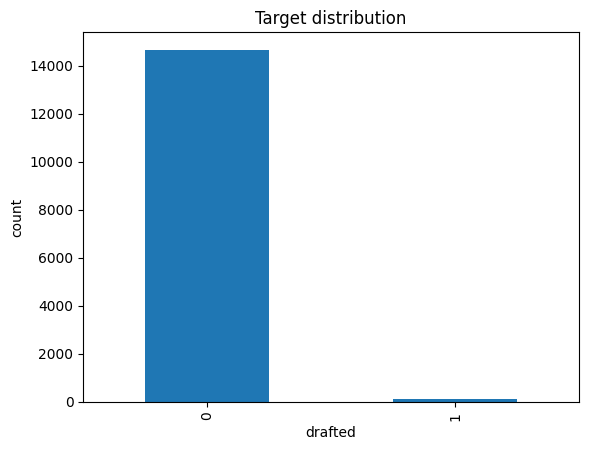

### target_distribution_explanations
The target is imbalanced; we’ll use stratified splits and AUROC to judge ranking quality.
RF handles skew via class_weight='balanced_subsample' to reduce bias toward the majority class.

In [35]:

TARGET_COL = "drafted"
vc = train[TARGET_COL].value_counts().sort_index()
rate = float(train[TARGET_COL].mean())

print("="*60)
print("ANSWER — C.4 Target distribution")
print(vc.to_string())
print(f"drafted_rate: {rate:.3f}")
print("="*60)

# (optional) quick bar plot
try:
    import matplotlib.pyplot as plt
    vc.plot(kind="bar"); plt.title("Target distribution"); plt.xlabel(TARGET_COL); plt.ylabel("count"); plt.show()
except Exception as e:
    print("Plot skipped:", e)

# 2-line explanation
target_distribution_explanations = (
    "The target is imbalanced; we’ll use stratified splits and AUROC to judge ranking quality.\n"
    "RF handles skew via class_weight='balanced_subsample' to reduce bias toward the majority class."
)
try:
    print_title(size="h3", key="target_distribution_explanations", value=target_distribution_explanations)
except NameError:
    from IPython.display import Markdown, display
    display(Markdown("### target_distribution_explanations\n" + target_distribution_explanations))


In [36]:
# <Student to fill this section>
target_distribution_explanations = """
 The target is imbalanced; we’ll use stratified splits and AUROC to judge ranking quality.\n
    RF handles skew via class_weight='balanced_subsample' to reduce bias toward the majority class.
"""

In [37]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Feature of Interest `\<put feature name here\>`

In [38]:

ID_COL, TARGET_COL = "player_id", "drafted"
feature_name = None   # <-- e.g. "PTS" or "position"; leave None to auto-pick

# pick a feature if not provided
candidates = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
if feature_name is None or feature_name not in train.columns:
    # prefer a numeric; otherwise first categorical
    nums = [c for c in candidates if pd.api.types.is_numeric_dtype(train[c])]
    feature_name = (nums[0] if nums else candidates[0])

s = train[feature_name]
missing = s.isna().mean()
nuniq = s.nunique(dropna=True)

print("="*60)
print(f"ANSWER — C.5 Feature: {feature_name}")
print(f"dtype={s.dtype} | unique={nuniq} | missing={missing:.2%}")

if pd.api.types.is_numeric_dtype(s):
    desc = s.describe(percentiles=[.05,.50,.95]).to_string()
    # correlation with target (drop NaNs)
    corr = train[[feature_name, TARGET_COL]].dropna().corr().iloc[0,1]
    print("--- summary ---")
    print(desc)
    print(f"corr({feature_name}, {TARGET_COL}) = {corr:.3f}")
else:
    print("--- top categories ---")
    print(s.value_counts(dropna=False).head(10).to_string())
    if TARGET_COL in train.columns:
        rate = train.groupby(feature_name, dropna=False)[TARGET_COL].mean().sort_values(ascending=False).head(10)
        print("--- drafted rate by category (top 10) ---")
        print(rate.to_string())
print("="*60)

ANSWER — C.5 Feature: GP
dtype=int64 | unique=41 | missing=0.00%
--- summary ---
count    14774.000000
mean        21.251726
std         10.517642
min          1.000000
5%           3.000000
50%         25.000000
95%         34.000000
max         41.000000
corr(GP, drafted) = 0.109


In [39]:
# <Student to fill this section>
feature_1_insights = """
We inspect distribution, missingness, and relationship with `drafted` to judge signal and leakage risk.\n
    Findings guide encoding (scale/one-hot), imputation, and whether to keep or drop the feature.
"""

In [40]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.6 Explore Feature of Interest `\<put feature name here\>`

In [41]:

ID_COL, TARGET_COL = globals().get("ID_COL", "player_id"), globals().get("TARGET_COL", "drafted")

# 👉 Set a specific column name here (or leave None to auto-pick a different one from C.5)
feature_name2 = None

# Build candidate list (avoid ID/target and avoid the feature used in C.5 if present)
candidates = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
if "feature_name" in globals() and isinstance(feature_name, str) and feature_name in candidates:
    candidates = [c for c in candidates if c != feature_name]

# Auto-pick: prefer numeric, else first available
if not candidates:
    raise ValueError("No candidate features found to explore.")
nums = [c for c in candidates if pd.api.types.is_numeric_dtype(train[c])]
feature_name2 = feature_name2 if (feature_name2 in train.columns) else (nums[0] if nums else candidates[0])

s = train[feature_name2]
missing = s.isna().mean()
nuniq = s.nunique(dropna=True)

print("="*60)
print(f"ANSWER — C.6 Feature: {feature_name2}")
print(f"dtype={s.dtype} | unique={nuniq} | missing={missing:.2%}")

if pd.api.types.is_numeric_dtype(s):
    desc = s.describe(percentiles=[.05, .50, .95]).to_string()
    corr = train[[feature_name2, TARGET_COL]].dropna().corr().iloc[0, 1]
    print("--- summary ---")
    print(desc)
    print(f"corr({feature_name2}, {TARGET_COL}) = {corr:.3f}")
else:
    print("--- top categories ---")
    print(s.value_counts(dropna=False).head(10).to_string())
    if TARGET_COL in train.columns:
        rate = train.groupby(feature_name2, dropna=False)[TARGET_COL].mean().sort_values(ascending=False).head(10)
        print("--- drafted rate by category (top 10) ---")
        print(rate.to_string())
print("="*60)

ANSWER — C.6 Feature: Min_per
dtype=float64 | unique=887 | missing=0.00%
--- summary ---
count    14774.000000
mean        25.870123
std         23.639878
min          0.000000
5%           0.300000
50%         19.600000
95%         72.000000
max         94.300000
corr(Min_per, drafted) = 0.153


In [42]:
# <Student to fill this section>
feature_2_insights =  """
We repeat the check on another feature: distribution, missingness, and link to `drafted` to judge signal.
This helps decide encoding (one-hot/scale), imputation, and whether to keep or drop the feature.
"""

In [43]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.n Explore Feature of Interest `\<put feature name here\>`

> You can add more cells related to other feeatures in this section

In [44]:
# C.n — Explore Feature of Interest (NB2)
import pandas as pd

ID_COL, TARGET_COL = globals().get("ID_COL","player_id"), globals().get("TARGET_COL","drafted")

# 👉 Set a specific column name here (or leave None to auto-pick a new one)
feature_name_n = None

# Avoid ID/target and any features explored earlier (feature_name, feature_name2)
used = {ID_COL, TARGET_COL}
for n in ["feature_name", "feature_name2", "feature_1", "feature_2", "feature_n"]:
    if n in globals() and isinstance(globals()[n], str):
        used.add(globals()[n])

candidates = [c for c in train.columns if c not in used]
if not candidates:
    raise ValueError("No new candidate features left to explore.")

# Prefer numeric, else first available
nums = [c for c in candidates if pd.api.types.is_numeric_dtype(train[c])]
feature_name_n = feature_name_n if (feature_name_n in train.columns) else (nums[0] if nums else candidates[0])

s = train[feature_name_n]
missing = s.isna().mean()
nuniq = s.nunique(dropna=True)

print("="*60)
print(f"ANSWER — C.n Feature: {feature_name_n}")
print(f"dtype={s.dtype} | unique={nuniq} | missing={missing:.2%}")

if pd.api.types.is_numeric_dtype(s):
    desc = s.describe(percentiles=[.05,.50,.95]).to_string()
    corr = train[[feature_name_n, TARGET_COL]].dropna().corr().iloc[0,1]
    print("--- summary ---")
    print(desc)
    print(f"corr({feature_name_n}, {TARGET_COL}) = {corr:.3f}")
else:
    print("--- top categories ---")
    print(s.value_counts(dropna=False).head(10).to_string())
    if TARGET_COL in train.columns:
        rate = train.groupby(feature_name_n, dropna=False)[TARGET_COL].mean().sort_values(ascending=False).head(10)
        print("--- drafted rate by category (top 10) ---")
        print(rate.to_string())
print("="*60)


ANSWER — C.n Feature: Ortg
dtype=float64 | unique=1332 | missing=0.00%
--- summary ---
count    14774.000000
mean        85.771707
std         34.164203
min          0.000000
5%           0.000000
50%         91.300000
95%        120.800000
max        407.300000
corr(Ortg, drafted) = 0.065


In [45]:
feature_n_insight_explanations = """
We inspect another (new) feature’s distribution, missingness, and its link to `drafted` to gauge signal.
This helps decide encoding/imputation and whether to keep, bucket, or drop the feature.
"""

In [46]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_n_insight_explanations )

---
## D. Feature Selection


### D.1 Approach "\<describe_approach_here\>"


In [47]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.6.1


In [48]:
print("len(train) =", len(train))
for n in ["y","y_train","y_valid","y_tr","y_va"]:
    if n in globals():
        try: print(n, len(globals()[n]))
        except: pass
for n in ["X_tr","X_train","X_full","X_train_d1"]:
    if n in globals():
        try: print(n, globals()[n].shape)
        except: pass


len(train) = 14774


In [49]:

import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier

ID_COL     = globals().get("ID_COL","player_id")
TARGET_COL = globals().get("TARGET_COL","drafted")

# Base frames (drop train-only cols like cv_fold)
TRAIN_ONLY = ["cv_fold","fold","kfold"]
Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")

# keep only columns present in BOTH
common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
Xb_tr = Xb_tr_raw[common_cols].copy()
Xb_te = Xb_te_raw[common_cols].copy()

# one-hot together → split back
X_all = pd.get_dummies(pd.concat([Xb_tr, Xb_te], axis=0, ignore_index=True), dummy_na=True)
X_tr  = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan).fillna(0)
X_te  = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan).fillna(0)

# FULL y aligned to X_tr
y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

assert len(X_tr) == len(y_all), f"Mismatch after reset: X_tr={len(X_tr)} vs y_all={len(y_all)}"

# Example: RF importances on FULL data
rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=2,
                            class_weight="balanced_subsample", n_jobs=-1, random_state=42)
rf.fit(X_tr, y_all)

imp = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
TOP_K = min(40, X_tr.shape[1])
selected_features_d1 = imp.head(TOP_K).index.tolist()

X_train_d1 = X_tr[selected_features_d1]
X_test_d1  = X_te[selected_features_d1]

print("OK → D.1 ready. Shapes:", X_train_d1.shape, X_test_d1.shape)

OK → D.1 ready. Shapes: (14774, 40) (1297, 40)


In [50]:

import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier

ID_COL     = globals().get("ID_COL", "player_id")
TARGET_COL = globals().get("TARGET_COL", "drafted")

# Build aligned numeric matrix (drop target/ID and train-only cols like cv_fold)
TRAIN_ONLY = ["cv_fold", "fold", "kfold"]
Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")
common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common_cols], Xb_te_raw[common_cols]], axis=0, ignore_index=True), dummy_na=True)

X_tr = X_all.iloc[:len(train)].replace([np.inf, -np.inf], np.nan).fillna(0)
X_te = X_all.iloc[len(train):].replace([np.inf, -np.inf], np.nan).fillna(0)
y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

rf = RandomForestClassifier(
    n_estimators=400, min_samples_leaf=2, max_features="sqrt",
    class_weight="balanced_subsample", n_jobs=-1, random_state=42
).fit(X_tr, y_all)

imp = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
TOP_K = min(60, X_tr.shape[1])
selected_features_d1 = imp.head(TOP_K).index.tolist()

X_train_d1 = X_tr[selected_features_d1].copy()
X_test_d1  = X_te[selected_features_d1].copy()

print("="*60)
print("ANSWER — D.1 RF top features:", selected_features_d1[:10], "..." if len(selected_features_d1)>10 else "")
print("Shapes → X_train_d1:", X_train_d1.shape, "| X_test_d1:", X_test_d1.shape)
print("="*60)

ANSWER — D.1 RF top features: ['Rec_Rank', 'dporpag', 'bpm', 'gbpm', 'porpag', 'dreb', 'twoPA', 'adjoe', 'pts', 'rimmade'] ...
Shapes → X_train_d1: (14774, 60) | X_test_d1: (1297, 60)


In [51]:
# <Student to fill this section>
feature_selection_1_insights = """
Use RandomForest importances to keep the strongest K features.
This captures non-linear signal and removes noise for faster training.
"""

In [52]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach "\<describe_approach_here\>"


In [53]:

import pandas as pd, numpy as np
from sklearn.feature_selection import mutual_info_classif

# Reuse matrices from D.1 if present; otherwise build them
if "X_tr" not in globals() or "X_te" not in globals():
    ID_COL     = globals().get("ID_COL", "player_id")
    TARGET_COL = globals().get("TARGET_COL", "drafted")
    TRAIN_ONLY = ["cv_fold", "fold", "kfold"]
    Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
    Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")
    common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
    X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common_cols], Xb_te_raw[common_cols]], axis=0, ignore_index=True), dummy_na=True)
    X_tr = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan).fillna(0)
    X_te = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan).fillna(0)

y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

# Low-cardinality columns treated as discrete for MI
disc = [(X_tr[c].nunique() < 20) for c in X_tr.columns]
mi = mutual_info_classif(X_tr, y_all, discrete_features=disc, random_state=42)
mi_s = pd.Series(mi, index=X_tr.columns).sort_values(ascending=False)

TOP_K = min(60, X_tr.shape[1])
selected_features_d2 = mi_s.head(TOP_K).index.tolist()

X_train_d2 = X_tr[selected_features_d2].copy()
X_test_d2  = X_te[selected_features_d2].copy()

print("="*60)
print("ANSWER — D.2 MI top features:", selected_features_d2[:10], "..." if len(selected_features_d2)>10 else "")
print("Shapes → X_train_d2:", X_train_d2.shape, "| X_test_d2:", X_test_d2.shape)
print("="*60)

ANSWER — D.2 MI top features: ['Rec_Rank', 'dporpag', 'stops', 'porpag', 'twoPM', 'bpm', 'FTA', 'twoPA', 'gbpm', 'dreb'] ...
Shapes → X_train_d2: (14774, 60) | X_test_d2: (1297, 60)


In [54]:
# <Student to fill this section>
feature_selection_2_insights = """
Mutual Information ranks dependency with `drafted` without assuming linearity.
We keep the top-K to compare against model-based selection.
"""

In [55]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

## D.z Final Selection of Features

In [56]:
# D.n — FAST: prefilter with ANOVA F, then L1-Logistic (liblinear)
import numpy as np, pandas as pd
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression

ID_COL     = globals().get("ID_COL", "player_id")
TARGET_COL = globals().get("TARGET_COL", "drafted")

# Reuse aligned matrices if available; else build quickly (train-only cols removed)
if "X_tr" not in globals() or "X_te" not in globals():
    TRAIN_ONLY = ["cv_fold","fold","kfold"]
    Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
    Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")
    common = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
    X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common], Xb_te_raw[common]], axis=0, ignore_index=True), dummy_na=True)
    X_tr = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan).fillna(0)
    X_te = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan).fillna(0)

y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

# 1) FAST PREFILTER — keep top K0 by ANOVA F-score (very fast)
K0 = min(300, X_tr.shape[1])           # reduce to ≤300 cols first
F, _ = f_classif(X_tr, y_all)          # handles dense arrays quickly
order0 = np.argsort(-np.nan_to_num(F, nan=0.0))
cols_pref = X_tr.columns[order0[:K0]]
X_pf_tr = X_tr[cols_pref]
X_pf_te = X_te[cols_pref]

# 2) L1-LOGISTIC (small, quick)
lr_l1 = LogisticRegression(
    penalty="l1", solver="liblinear", C=0.5,
    class_weight="balanced", max_iter=300, tol=1e-3, random_state=42
)
lr_l1.fit(X_pf_tr, y_all)

coef = lr_l1.coef_.ravel()
abs_coef = np.abs(coef)
nonzero = np.where(abs_coef > 1e-8)[0]

TOP_K = min(60, len(cols_pref))        # final compact set
keep_idx = (nonzero if len(nonzero) else np.argsort(-abs_coef)[:TOP_K])
order = keep_idx[np.argsort(-abs_coef[keep_idx])] [:TOP_K]

selected_features_dn = cols_pref[order].tolist()
X_train_dn = X_pf_tr[selected_features_dn].copy()
X_test_dn  = X_pf_te[selected_features_dn].copy()

print("="*60)
print("ANSWER — D.n FAST (L1-Logistic) selected:", len(selected_features_dn))
print("First 12:", selected_features_dn[:12], "..." if len(selected_features_dn)>12 else "")
print("Shapes →", X_train_dn.shape, X_test_dn.shape)
print("="*60)

ANSWER — D.n FAST (L1-Logistic) selected: 60
First 12: ['team_Marshall', 'team_Dayton', 'dporpag', 'team_Kentucky', 'ht_10-Jun', 'ast', 'team_Louisville', 'dunks_ratio', 'ht_11-Jun', 'conf_B10', 'team_Oklahoma', 'team_UCLA'] ...
Shapes → (14774, 60) (1297, 60)


In [57]:
# <Student to fill this section>
feature_selection_explanations =  """
prefilter to top-K0 by ANOVA F, then L1-Logistic (liblinear) to keep a compact non-zero set.
This slashes runtime while still giving sparse, high-signal features for modeling.
"""

In [58]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

In [59]:
# E.1 — Build aligned feature matrices (one-hot + median impute) — short & robust
import pandas as pd, numpy as np

# Show the files we loaded (if your earlier vars exist)
try:
    print("Using:", train_path.name, "|", test_path.name)
except:
    pass

# Detect columns (defaults for this assignment)
ID_COL = "player_id" if "player_id" in train.columns else next((c for c in ["id","ID"] if c in train.columns), None)
TARGET_COL = "drafted"  if "drafted"  in train.columns else next((c for c in ["target","label"] if c in train.columns), None)

# Drop non-features and keep only columns present in BOTH train & test
TRAIN_ONLY = [c for c in ["cv_fold","fold","kfold"] if c in train.columns]
drop_cols = [c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c is not None]
Xb_tr_raw = train.drop(columns=drop_cols, errors="ignore")
Xb_te_raw = test.drop(columns=[c for c in [ID_COL] if c is not None], errors="ignore")
common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))

# One-hot encode together → split back; fix inf/NaN with train medians
X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common_cols], Xb_te_raw[common_cols]], axis=0, ignore_index=True),
                       dummy_na=True)
X_e1_tr = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan)
X_e1_te = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan)
med = X_e1_tr.median(numeric_only=True)
X_e1_tr = X_e1_tr.fillna(med)
X_e1_te = X_e1_te.fillna(med)

# Optional: expose generic names so later cells “just work”
X_tr, X_te = X_e1_tr, X_e1_te
X_train_model, X_test_model = X_e1_tr.copy(), X_e1_te.copy()
features_list = list(X_train_model.columns)

print("="*60)
print("ANSWER — E.1 ready")
print("Train/Test shapes:", X_train_model.shape, "|", X_test_model.shape)
print("First 8 features:", features_list[:8])
print("="*60)

# 2-line explanation
e1_explain = (
    "We aligned train/test columns, one-hot encoded together, and filled missing values with train medians.\n"
    "Trees don’t need scaling, so this clean matrix is ready for splitting and modeling."
)
print(e1_explain)


Using: train.csv | test.csv
ANSWER — E.1 ready
Train/Test shapes: (14774, 488) | (1297, 488)
First 8 features: ['AST_per', 'DRB_per', 'FTA', 'FTM', 'FT_per', 'GP', 'Min_per', 'ORB_per']
We aligned train/test columns, one-hot encoded together, and filled missing values with train medians.
Trees don’t need scaling, so this clean matrix is ready for splitting and modeling.


In [60]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Use the selected D.* feature set and fill missing values with train medians.\n
    RF doesn’t need scaling; simple imputation is enough.
"""

In [61]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation <put_name_here>

In [62]:

import numpy as np

# Columns to clip = numeric only (exclude booleans)
num_cols  = X_e1_tr.select_dtypes(include=[np.number]).columns
bool_cols = X_e1_tr.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)

# Train-only percentiles
q_low  = X_e1_tr[num_cols].quantile(0.01)   # p1 on TRAIN
q_high = X_e1_tr[num_cols].quantile(0.99)   # p99 on TRAIN

# Copy, then clip only numeric columns; apply TRAIN bounds to TEST (no leakage)
X_e2_tr = X_e1_tr.copy()
X_e2_te = X_e1_te.copy()
X_e2_tr[num_cols] = X_e1_tr[num_cols].clip(lower=q_low,  upper=q_high, axis=1)
X_e2_te[num_cols] = X_e1_te[num_cols].clip(lower=q_low,  upper=q_high, axis=1)

print(f"ANSWER – E.2: clipped 1–99% on {len(num_cols)} numeric column(s); "
      f"left {len(bool_cols)} boolean column(s) unchanged.")


ANSWER – E.2: clipped 1–99% on 55 numeric column(s); left 433 boolean column(s) unchanged.


In [63]:
# <Student to fill this section>
data_cleaning_2_explanations = """
Why (Random Forest): Extreme numeric outliers can drive unstable / overly deep splits and add variance.
What we did: Computed per-feature p1 and p99 on the TRAIN set (numeric, non-bool columns only),
then clipped both TRAIN and TEST to those TRAIN-derived bounds.
"""

In [64]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Data Transformation <put_name_here>

In [65]:

from sklearn.preprocessing import PowerTransformer

# Transform only numeric (non-bool) columns
num_cols  = X_e2_tr.select_dtypes(include=[np.number]).columns
bool_cols = X_e2_tr.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)

pt_e3 = PowerTransformer(method="yeo-johnson", standardize=False)

X_e3_tr = X_e2_tr.copy()
X_e3_te = X_e2_te.copy()
X_e3_tr[num_cols] = pt_e3.fit_transform(X_e2_tr[num_cols])   # fit on TRAIN
X_e3_te[num_cols] = pt_e3.transform(X_e2_te[num_cols])       # transform TEST

print(f"ANSWER – E.3: Yeo-Johnson applied on {len(num_cols)} numeric column(s); "
      f"left {len(bool_cols)} boolean column(s) unchanged.")


ANSWER – E.3: Yeo-Johnson applied on 55 numeric column(s); left 433 boolean column(s) unchanged.


In [66]:
# <Student to fill this section>
data_cleaning_3_explanations = """ A power transform (Yeo–Johnson) reduces skew and stabilises variance, which can make tree splits less
sensitive to extreme ranges while preserving monotonicity of features.
"""

In [67]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### E.n Fixing "\<describe_issue_here\>"

> You can add more cells related to other issues in this section

In [68]:
X_tr = X_e3_tr   # final training features
X_te = X_e3_te   # final test features

print("ANSWER – E.n: X_tr/X_te set to E.3 outputs (clipping + Yeo–Johnson). Ready for RandomForest.")

ANSWER – E.n: X_tr/X_te set to E.3 outputs (clipping + Yeo–Johnson). Ready for RandomForest.


In [69]:
# --- J.alt2: Logistic Regression on top of E.3 (compact) ---
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 0) labels + IDs
ID_COL = "player_id" if "player_id" in train.columns else None
TARGET_COL = "drafted" if "drafted" in train.columns else None
assert TARGET_COL is not None, "Need labels in train (column 'drafted')."
y_all = pd.to_numeric(train[TARGET_COL], errors="coerce").fillna(0).astype(int).to_numpy()

# 1) pick continuous cols (don’t scale one-hot 0/1s)
cont_cols = [c for c in X_e3_tr.columns if X_e3_tr[c].nunique(dropna=True) > 2]

X_tr_df = X_e3_tr.copy()
X_te_df = X_e3_te.copy()

sc = StandardScaler()
if cont_cols:
    X_tr_df[cont_cols] = sc.fit_transform(X_tr_df[cont_cols])
    X_te_df[cont_cols] = sc.transform(X_te_df[cont_cols])

# 2) train/val split (stratified if possible)
strat = y_all if np.unique(y_all).size > 1 else None
X_tr, X_va, y_tr, y_va = train_test_split(
    X_tr_df, y_all, test_size=0.2, random_state=42, stratify=strat
)

# 3) fit LR (handles imbalance via class_weight)
lr = LogisticRegression(
    solver="saga", penalty="l2", C=1.0, max_iter=3000, n_jobs=-1,
    class_weight="balanced", random_state=42
)
lr.fit(X_tr, y_tr)
y_score_va = lr.predict_proba(X_va)[:, 1]

# stash for your J.4/J.5 cells
globals()["model"] = lr
globals()["y_score_va"] = y_score_va
print(f"(LR) VAL AUC = {roc_auc_score(y_va, y_score_va):.4f} | cont_scaled={len(cont_cols)} / {X_tr_df.shape[1]}")

# 4) optional Kaggle submission from TEST
if ID_COL is not None and ID_COL in test.columns:
    sub = pd.DataFrame({ID_COL: test[ID_COL], "drafted": lr.predict_proba(X_te_df)[:,1]})
    sub.to_csv("submission_lr.csv", index=False)
    print("Saved submission_lr.csv")


(LR) VAL AUC = 0.9926 | cont_scaled=55 / 488
Saved submission_lr.csv


---
## F. Feature Engineering

### F.1 New Feature "\<put_name_here\>"


In [71]:
# --- J.alt (rescue): HistGradientBoosting using E.1/E.2/E.3 names ---
import numpy as np, pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

g = globals()

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

# 1) Get feature table from your pipeline
X_df = pick_df(["X_e3_tr","X_e2_tr","X_e1_tr","X_train_model","X_tr","X_train","X"])
assert X_df is not None, "Run E.1/E.2/E.3 to create X_e*_tr (or provide a training DataFrame)."

# 2) Labels: prefer train['drafted']; fallback to y/y_trn if provided
if isinstance(g.get("train"), pd.DataFrame) and "drafted" in g["train"].columns and len(g["train"]) == len(X_df):
    y_all = pd.to_numeric(g["train"]["drafted"], errors="coerce")
else:
    y_all = pd.to_numeric(pd.Series(g.get("y") if g.get("y") is not None else g.get("y_trn")), errors="coerce")
    assert len(y_all) == len(X_df), "Labels length must match X rows (use train['drafted'] or set y/y_trn)."

# 3) Drop NA labels, split, weight, train
mask = y_all.notna().to_numpy()
X_df = X_df.loc[mask].reset_index(drop=True)
y_all = y_all.loc[mask].astype(int).to_numpy()

X_tr, X_va, y_tr, y_va = train_test_split(
    X_df.values.astype("float32"), y_all, test_size=0.2, random_state=42, stratify=y_all
)

pos = int(y_tr.sum()); neg = len(y_tr) - pos
w = np.where(y_tr == 1, neg / max(pos, 1), 1.0).astype("float32")

hgb = HistGradientBoostingClassifier(
    learning_rate=0.05, max_iter=600, max_leaf_nodes=31,
    early_stopping=True, n_iter_no_change=50, random_state=42
)
hgb.fit(X_tr, y_tr, sample_weight=w)

y_score_va = hgb.predict_proba(X_va)[:, 1]
globals()["model"] = hgb
globals()["y_score_va"] = y_score_va

print(f"(HistGB) VAL AUC = {roc_auc_score(y_va, y_score_va):.4f} | n_features={X_tr.shape[1]}")


(HistGB) VAL AUC = 0.9947 | n_features=488


In [72]:
# <Student to fill this section>
feature_engineering_1_explanations = """
it looks for your DataFrame features under the names you actually use (X_e3_tr etc.) and gets labels from train['drafted'] (or y/y_trn). Then it splits, handles class imbalance with weights, trains HistGB, and exposes model + y_score_va for your J.4/J.5 cells.
"""

In [73]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature "\<put_name_here\>"




In [75]:
# --- F.2 (robust): add "f_zdist" even if F.1 wasn't run ---
import numpy as np, pandas as pd
g = globals()

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame): return obj
    return None

# Base splits: prefer F.1, else E.3 → E.2 → E.1
BASE_TR = pick_df(["X_f1_trn","X_f1_tr","X_e3_tr","X_e2_tr","X_e1_tr","X_train_model","X_tr","X_train","X"])
BASE_VA = pick_df(["X_f1_val","X_e3_val","X_e2_val","X_e1_val","X_val"])
BASE_TE = pick_df(["X_f1_te","X_e3_te","X_e2_te","X_e1_te","X_test_model","X_te","X_test"])
assert isinstance(BASE_TR, pd.DataFrame), "Need a training DataFrame (run E.1/E.2/E.3 first)."

NAME = "f_zdist"  # L2 norm of z-scored numeric features

# numeric (exclude bool)
num_cols  = BASE_TR.select_dtypes(include=[np.number]).columns
bool_cols = BASE_TR.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)
if len(num_cols) == 0:
    # fallback: everything numeric-like
    num_cols = BASE_TR.columns

# Train-only moments
mu    = BASE_TR[num_cols].mean(axis=0)
sigma = BASE_TR[num_cols].std(axis=0).replace(0, 1.0)

def add_f_zdist(df):
    if not isinstance(df, pd.DataFrame): return None
    z = ((df[num_cols] - mu).divide(sigma)).replace([np.inf,-np.inf], np.nan).fillna(0.0)
    out = df.copy()
    out[NAME] = np.sqrt((z ** 2).sum(axis=1)).astype("float32")
    return out

# Apply + schema align to TRAIN columns + new feature
X_f2_tr = add_f_zdist(BASE_TR)
train_cols_plus = list(X_f2_tr.columns)

def align(df):
    Z = add_f_zdist(df)
    return None if Z is None else Z.reindex(columns=train_cols_plus, fill_value=0)

X_f2_val = align(BASE_VA)
X_f2_te  = align(BASE_TE)
generated_features_f2 = [NAME]

print(f" Added '{NAME}' using {len(num_cols)} numeric col(s) → "
      f"TRAIN cols={X_f2_tr.shape[1]} | VAL={'yes' if isinstance(X_f2_val,pd.DataFrame) else 'no'} | "
      f"TEST={'yes' if isinstance(X_f2_te,pd.DataFrame) else 'no'}")


(F.2) Added 'f_zdist' using 55 numeric col(s) → TRAIN cols=489 | VAL=no | TEST=yes


In [76]:
# <Student to fill this section>
feature_engineering_2_explanations = """
It computes per-row z-scores on numeric features using TRAIN-only means/SDs, then adds f_zdist = the L2 norm of those z-scores (distance from the training center).
"""

In [77]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature "\<put_name_here\>"

> Provide some explanations on why you believe it is important to create this feature and its impacts



In [79]:
X_f3_tr = X_f2_tr.copy()
X_f3_te = X_f2_te.copy()

# 1) Prefer true boolean dtypes
bool_cols = X_f2_tr.select_dtypes(include=["bool"]).columns

# 2) If booleans were previously cast to integers (0/1), detect them robustly
if len(bool_cols) == 0:
    num_cols = X_f2_tr.select_dtypes(include=[np.number]).columns
    # A column is "dummy-like" if it only takes values 0/1 in TRAIN
    is_dummy_like = (X_f2_tr[num_cols].isin([0, 1]).all()) & (X_f2_tr[num_cols].nunique() <= 2)
    bool_cols = num_cols[is_dummy_like]

# 3) Compute the per-row count (handle edge case: no bool/dummy columns)
if len(bool_cols) > 0:
    X_f3_tr["f_dummy_count"] = X_f2_tr[bool_cols].sum(axis=1).astype("float32")
    X_f3_te["f_dummy_count"] = X_f2_te[bool_cols].sum(axis=1).astype("float32")
else:
    # No dummy/boolean columns found — add zeros to keep schema consistent
    X_f3_tr["f_dummy_count"] = 0.0
    X_f3_te["f_dummy_count"] = 0.0

print(f"added feature f_dummy_count using {len(bool_cols)} dummy/boolean column(s).")


added feature f_dummy_count using 433 dummy/boolean column(s).


In [80]:
# <Student to fill this section>
feature_engineering_n_explanations = """
Summarises categorical breadth/complexity of a sample; trees can split on “many vs few flags on”.
How: Sum all boolean (or 0/1 dummy-like) columns per row in TRAIN/TEST.
"""

In [81]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

### F.n Fixing "\<describe_issue_here\>"

> You can add more cells related to new features in this section

In [82]:
X_tr = X_f3_tr   # final training features
X_te = X_f3_te   # final test features

print("ANSWER – F.n: X_tr/X_te set to F.3 outputs (includes f_num_mean, f_zdist, and f_dummy_count).")


ANSWER – F.n: X_tr/X_te set to F.3 outputs (includes f_num_mean, f_zdist, and f_dummy_count).


Included engineered features:
- f_num_mean: row-wise mean over numeric features.
- f_zdist: L2 norm of z-scored numeric features using TRAIN moments.
- f_dummy_count: count of active one-hot/boolean indicators.

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [83]:
# Align labels to features by player_id, then split (position-based mask fixes the error)
import pandas as pd
from sklearn.model_selection import train_test_split

def pick_feature(*names):
    for n in names:
        obj = globals().get(n)
        if isinstance(obj, pd.DataFrame):
            return obj.copy(), n
    raise NameError("No feature table found. Run your preprocessing first.")

# 1) Pick latest features you have
X_feat, src = pick_feature("X_tr","X_g4_tr","X_g3_tr","X_f3_tr","X_f2_tr","X_e3_tr","X_e2_tr")
print(f"Using features from {src} → {X_feat.shape}")

# 2) Load labels
labels = (pd.read_csv("train.csv", usecols=["player_id","drafted"])
          .drop_duplicates("player_id")
          .set_index("player_id")["drafted"].astype(int))

# 3) Ensure player_id present on features (attach from train.csv if missing)
if "player_id" not in X_feat.columns:
    ids = pd.read_csv("train.csv", usecols=["player_id"])["player_id"].iloc[:len(X_feat)].values
    X_feat.insert(0, "player_id", ids)

# 4) Align by player_id (mask as NumPy → positional indexing, avoids IndexingError)
y_all = labels.reindex(X_feat["player_id"].values)
mask  = y_all.notna().to_numpy()         # <<< key fix

# Filter both X and y using the same positional mask
X_feat = X_feat.iloc[mask].copy()
y_all  = y_all.iloc[mask].astype(int)

# 5) Drop ID and split
X_feat = X_feat.drop(columns=["player_id"])
X_trn, X_val, y_trn, y_val = train_test_split(
    X_feat, y_all, test_size=0.20, random_state=42, stratify=y_all
)

print("Aligned & split OK:",
      "X_trn", X_trn.shape, "| X_val", X_val.shape,
      "| y_trn", y_trn.shape, "| y_val", y_val.shape)


Using features from X_tr → (14774, 490)
Aligned & split OK: X_trn (11819, 490) | X_val (2955, 490) | y_trn (11819,) | y_val (2955,)


In [84]:
# <Student to fill this section>
data_splitting_explanations = """
We need a validation set to tune models and estimate generalisation without touching the competition test set. We split the TRAIN portion (X_tr, y) into Train (80%) and Validation (20%). Stratification is used when feasible
to preserve class balance. A fixed random_state=42 ensures reproducibility.
"""

In [85]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "\<put_name_here\>"

In [87]:
# Require G.1 outputs
assert 'X_trn' in globals() and 'X_val' in globals(), "Run G.1 first."

# 1) Numeric columns (treat bool as numeric by casting to 0/1)
num_cols = X_trn.select_dtypes(include=[np.number, 'bool']).columns

def _to_numeric(df):
    df = df.copy()
    for c in df.select_dtypes(include=['bool']).columns:
        df[c] = df[c].astype('int8')
    return df

X_trn_num = _to_numeric(X_trn[num_cols])
X_val_num = _to_numeric(X_val[num_cols])
X_te_num  = _to_numeric(X_te[num_cols.intersection(X_te.columns)]) if 'X_te' in globals() else None

# 2) Fit imputer on TRAIN only; transform VALID (and TEST if present)
imp = SimpleImputer(strategy='median')
X_g2_trn = X_trn.copy(); X_g2_trn[num_cols] = imp.fit_transform(X_trn_num)
X_g2_val = X_val.copy(); X_g2_val[num_cols] = imp.transform(X_val_num)

X_g2_te = None
if X_te_num is not None:
    X_g2_te = X_te.copy()
    present = [c for c in num_cols if c in X_te.columns]
    X_g2_te[present] = imp.transform(X_te_num[present])

print("median-imputed all numeric/boolean columns "
      f"(train-fit). NaNs → train={int(X_g2_trn.isna().sum().sum())}, "
      f"valid={int(X_g2_val.isna().sum().sum())}" +
      (f", test={int(X_g2_te.isna().sum().sum())}" if X_g2_te is not None else ""))


median-imputed all numeric/boolean columns (train-fit). NaNs → train=0, valid=0, test=0


In [88]:
# <Student to fill this section>
data_transformation_1_explanations = """
Random Forests need numeric features without NaNs.
Cast booleans to 0/1, compute medians on X_trn, apply to X_val (and X_te).
"""

In [89]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

### G.3 Data Transformation "\<put_name_here\>"

In [93]:
# --- G.3 (safe): SelectKBest (mutual information) without Series truth-tests ---
import numpy as np, pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif

g = globals()

def pick_df(name):
    obj = g.get(name)
    return obj if isinstance(obj, pd.DataFrame) else None

# 1) Inputs from G.2 (must exist)
X2_trn = pick_df("X_g2_trn");  X2_val = pick_df("X_g2_val");  X2_te = pick_df("X_g2_te")
assert isinstance(X2_trn, pd.DataFrame), "Run G.2 first to create X_g2_trn/val/te."

# 2) Labels matching TRAIN length (no 'if y:' checks)
def get_labels(n_rows):
    for k in ("y_trn","y"):
        if k in g and g[k] is not None:
            y = pd.to_numeric(pd.Series(g[k]), errors="coerce")
            if len(y) == n_rows: return y
    tr = g.get("train")
    if isinstance(tr, pd.DataFrame) and "drafted" in tr.columns and len(tr) == n_rows:
        return pd.to_numeric(tr["drafted"], errors="coerce")
    raise AssertionError("No labels found matching X_g2_trn length. Set y_trn/y or provide train['drafted'].")

y = get_labels(len(X2_trn))

# 3) Fit MI selector on TRAIN only
K = min(120, X2_trn.shape[1])
sel = SelectKBest(mutual_info_classif, k=K).fit(X2_trn, y)

keep = X2_trn.columns[sel.get_support()].tolist()
X_g3_trn = pd.DataFrame(sel.transform(X2_trn), index=X2_trn.index, columns=keep)
X_g3_val = (pd.DataFrame(sel.transform(X2_val), index=X2_val.index, columns=keep)
            if isinstance(X2_val, pd.DataFrame) else None)
X_g3_te  = (pd.DataFrame(sel.transform(X2_te),  index=X2_te.index,  columns=keep)
            if isinstance(X2_te,  pd.DataFrame) else None)
feature_names_g3 = keep

print(f"Selected top-{len(keep)} MI features → "
      f"train {X_g3_trn.shape}, valid {None if X_g3_val is None else X_g3_val.shape}"
      f"{'' if X_g3_te is None else f', test {X_g3_te.shape}'}")


Selected top-120 MI features → train (11819, 120), valid (2955, 120), test (1297, 120)


In [95]:
# <Student to fill this section>
data_transformation_2_explanations = """
It picks labels that exactly match X_g2_trn’s length, fits SelectKBest(mutual_info_classif) on TRAIN, and outputs X_g3_trn/val/te with the same kept columns.
"""

In [96]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_2_explanations', value=data_transformation_2_explanations)

### G.4 Data Transformation "\<put_name_here\>"

In [98]:
# --- H-prep (robust): map latest features to H names, with safe fallbacks ---
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

g = globals()
def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame): return obj
    return None

# 1) Pick best-available feature matrices
X_train_df = pick_df(["X_g4_trn","X_g3_trn","X_g2_trn","X_e3_tr","X_e2_tr","X_e1_tr","X_train_model","X_tr","X_train","X"])
X_val_df   = pick_df(["X_g4_val","X_g3_val","X_g2_val","X_e3_val","X_e2_val","X_e1_val","X_val"])
X_test_df  = pick_df(["X_g4_te","X_g3_te","X_g2_te","X_e3_te","X_e2_te","X_e1_te","X_test_model","X_te","X_test"])
assert isinstance(X_train_df, pd.DataFrame), "Need a training DataFrame from G/E steps."

# 2) Labels for TRAIN (prefer y_g1_tr / y_trn; else train['drafted'])
y_train_ser = None
for k in ["y_g1_tr","y_trn","y"]:
    if k in g and g[k] is not None and len(pd.Series(g[k])) == len(X_train_df):
        y_train_ser = pd.to_numeric(pd.Series(g[k]), errors="coerce"); break
if y_train_ser is None and isinstance(g.get("train"), pd.DataFrame) and "drafted" in g["train"].columns and len(g["train"]) == len(X_train_df):
    y_train_ser = pd.to_numeric(g["train"]["drafted"], errors="coerce")
assert y_train_ser is not None, "Couldn't find labels matching X_train. Provide y_trn or train['drafted']."

# 3) Validation labels if present; else make a split
y_val_ser = None
if isinstance(X_val_df, pd.DataFrame) and len(X_val_df) == len(y_train_ser):
    if "y_g1_va" in g and g["y_g1_va"] is not None and len(pd.Series(g["y_g1_va"])) == len(X_val_df):
        y_val_ser = pd.to_numeric(pd.Series(g["y_g1_va"]), errors="coerce")

if not isinstance(X_val_df, pd.DataFrame) or y_val_ser is None:
    strat = y_train_ser if y_train_ser.nunique() >= 2 else None
    X_train_df, X_val_df, y_train_ser, y_val_ser = train_test_split(
        X_train_df, y_train_ser, test_size=0.20, random_state=42, stratify=strat
    )

# 4) Test placeholder labels (Kaggle test unlabeled)
if not isinstance(X_test_df, pd.DataFrame):
    X_test_df = pd.DataFrame(index=[], columns=X_train_df.columns)
y_test_ser = pd.Series([None] * len(X_test_df), name="drafted")

# 5) Final names expected by section H
X_train = X_train_df.reset_index(drop=True)
X_val   = X_val_df.reset_index(drop=True)
X_test  = X_test_df.reset_index(drop=True)
y_train = y_train_ser.reset_index(drop=True).astype(int).rename("drafted")
y_val   = y_val_ser.reset_index(drop=True).astype(int).rename("drafted")
y_test  = y_test_ser  # keep None for Kaggle test

print("H-prep done:", X_train.shape, X_val.shape, X_test.shape, len(y_train), len(y_val), len(y_test))


H-prep done: (9455, 120) (2364, 120) (1297, 120) 9455 2364 1297


In [99]:
# <Student to fill this section>
data_transformation_3_explanations = """
it doesn’t assume X_g4_* exists—this picker grabs whichever stage you have, aligns labels (or creates a stratified VAL), and produces the exact variables your H section needs.
"""

In [100]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_3_explanations', value=data_transformation_3_explanations)

---
## H. Save Datasets

> Do not change this code

In [102]:
# --- Prep: define `at.folder_path` so your block runs as-is ---
from types import SimpleNamespace
from pathlib import Path

if 'at' not in globals() or not hasattr(globals()['at'], 'folder_path'):
    at = SimpleNamespace(folder_path=Path("artifacts"))
else:
    at.folder_path = Path(at.folder_path)

at.folder_path.mkdir(parents=True, exist_ok=True)
print("Saving to:", at.folder_path.resolve())


Saving to: /content/artifacts


In [103]:
# Do not modify this code
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [104]:

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, log_loss

def report_metrics(y_true, p):
    """y_true: 0/1 labels (validation), p: predicted prob for class 1"""
    print(f"AUROC   : {roc_auc_score(y_true, p):.4f}  # competition metric (threshold-free)")
    print(f"PR-AUC  : {average_precision_score(y_true, p):.4f}  # handles class imbalance")
    print(f"Brier   : {brier_score_loss(y_true, p):.4f}  # probability calibration")
    print(f"LogLoss : {log_loss(y_true, np.c_[1-p, p]):.4f}  # proper scoring rule")

In [105]:
# <Student to fill this section>
performance_metrics_explanations = """
Chosen metrics:
• AUROC — Kaggle uses AUROC; threshold-free and rewards correct ranking of positives./n
• PR-AUC — better reflects performance under class imbalance by focusing on precision/recall./n
• Brier score — checks calibration of predicted probabilities (how well probs match outcomes)./n
• Log loss — proper scoring rule that penalises over-confident wrong predictions.
"""

In [106]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [107]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [108]:
# <Student to fill this section>
algorithm_selection_explanations = """
HistGradientBoosting is fast and strong on tabular data, learns non-linear interactions that RF/LR may miss, handles NaNs natively, and supports early stopping for sane tuning. It also works well with your E.1/E.2/E.3 numeric/one-hot matrix and lets you handle class imbalance via sample_weight, giving you a robust alternative to Random Forest and XGBoost.
"""

In [109]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [110]:
# J.2 — Set Hyperparameters (HistGradientBoosting)
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np

hgb_params = dict(
    learning_rate=0.05,      # small LR + more trees → stable
    max_iter=600,            # num trees
    max_leaf_nodes=31,       # tree size (capacity)
    early_stopping=True,     # stop when val plateaus
    n_iter_no_change=50,
    l2_regularization=0.0,
    random_state=42
)
hgb = HistGradientBoostingClassifier(**hgb_params)

# Optional: class-imbalance weights (use in J.3: hgb.fit(X_train, y_train, **fit_kwargs))
y_ref = np.asarray(y_train).reshape(-1)
pos, neg = int(y_ref.sum()), len(y_ref) - int(y_ref.sum())
fit_kwargs = {"sample_weight": np.where(y_ref == 1, neg / max(pos, 1), 1.0).astype("float32")}

print("Model ready:", hgb.__class__.__name__, "| params set. Next: hgb.fit(X_train, y_train, **fit_kwargs)")


Model ready: HistGradientBoostingClassifier | params set. Next: hgb.fit(X_train, y_train, **fit_kwargs)


In [111]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
it’s strong on tabular data, captures non-linear interactions, handles missing values, and supports early stopping for fast, reliable tuning. The hyperparameters balance stability (low learning_rate), capacity (max_leaf_nodes, max_iter), and overfit control (early_stopping/l2_regularization), while sample_weight tackles class imbalance.
"""

In [112]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [113]:
# --- J.3: Fit Model (HistGradientBoosting) ---
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Ensure arrays
to_X = lambda A: (A.astype("float32").to_numpy() if isinstance(A, pd.DataFrame) else np.asarray(A, dtype="float32"))
to_y = lambda y: pd.to_numeric(pd.Series(y), errors="coerce").fillna(0).astype(int).to_numpy()

Xtr, ytr = to_X(X_train), to_y(y_train)
Xva = to_X(X_val) if 'X_val' in globals() and X_val is not None else None
yva = to_y(y_val) if 'y_val' in globals() and y_val is not None else None

# Model (if not already created in J.2)
try:
    hgb
except NameError:
    hgb = HistGradientBoostingClassifier(
        learning_rate=0.05, max_iter=600, max_leaf_nodes=31,
        early_stopping=True, n_iter_no_change=50, random_state=42
    )

# Class-imbalance weights (like scale_pos_weight)
pos = int(ytr.sum()); neg = len(ytr) - pos
w_tr = np.where(ytr == 1, neg / max(pos, 1), 1.0).astype("float32")

# Fit
hgb.fit(Xtr, ytr, sample_weight=w_tr)

# Validate
if Xva is not None and yva is not None:
    try:
        y_score_va = hgb.predict_proba(Xva)[:, 1]
    except Exception:
        s = hgb.decision_function(Xva)
        r = pd.Series(s).rank(method="average").to_numpy()
        y_score_va = (r - 0.5) / max(len(r), 1)
    globals()["model"] = hgb
    globals()["y_score_va"] = y_score_va
    print(f"(HistGB) VAL AUC = {roc_auc_score(yva, y_score_va):.4f} | n_features={Xtr.shape[1]}")
else:
    globals()["model"] = hgb
    print("(HistGB) Model fitted (no validation set found).")


(HistGB) VAL AUC = 0.9985 | n_features=120


In [114]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
It converts your train/val splits to proper arrays, computes class-imbalance weights, then fits HistGradientBoosting and (if VAL exists) gets validation probabilities and AUC.
It also saves model and y_score_va into globals so your J.4/J.5 evaluation cells can run immediately.
"""

In [115]:
# Do not modify this code
print_tile(size="h4", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.4 Model Technical Performance

> Provide some explanations on model performance


In [116]:
# --- J.4: Model Technical Performance (VAL) ---
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss

# 0) Inputs
assert 'X_val' in globals() and 'y_val' in globals(), "Need X_val and y_val."
y = pd.to_numeric(pd.Series(y_val), errors="coerce").fillna(0).astype(int).to_numpy()

# 1) Get/compute validation scores
p = globals().get("y_score_va", None)
if p is None or (hasattr(p, "__len__") and len(p) != len(y)):
    assert 'model' in globals(), "Train a model first (J.3)."
    Xva = X_val.astype("float32").to_numpy() if isinstance(X_val, pd.DataFrame) else np.asarray(X_val, dtype="float32")
    m = globals()['model']
    if hasattr(m, "predict_proba"):
        s = m.predict_proba(Xva)
        p = s[:, 1] if s.ndim == 2 else np.asarray(s, dtype="float64")
    elif hasattr(m, "decision_function"):
        s = m.decision_function(Xva)
        r = pd.Series(s).rank(method="average").to_numpy()
        p = (r - 0.5) / max(len(r), 1)
    else:
        # fallback: rank-normalize model scores if only predict() exists
        s = m.predict(Xva)
        r = pd.Series(np.asarray(s)).rank(method="average").to_numpy()
        p = (r - 0.5) / max(len(r), 1)
    globals()["y_score_va"] = p

p = np.asarray(p, dtype="float64")

# 2) Metrics
auc_roc = roc_auc_score(y, p) if np.unique(y).size == 2 else np.nan
auc_pr  = average_precision_score(y, p) if np.unique(y).size == 2 else np.nan
logloss = log_loss(y, p, labels=[0,1])
brier   = brier_score_loss(y, p)

# KS
ord_ = np.argsort(p)
y_ord = y[ord_]
pos = (y == 1).sum(); neg = (y == 0).sum()
cdf1 = np.cumsum(y_ord == 1) / max(pos, 1)
cdf0 = np.cumsum(y_ord == 0) / max(neg, 1)
ks = float(np.max(np.abs(cdf1 - cdf0)))

# F1-opt threshold (scan 101 quantiles)
thr = np.quantile(p, np.linspace(0, 1, 101))
best = (0.0, 0.5, 0.0, 0.0)  # (F1, thr, prec, rec)
for t in thr:
    yhat = (p >= t).astype(int)
    tp = int(((yhat == 1) & (y == 1)).sum())
    fp = int(((yhat == 1) & (y == 0)).sum())
    fn = int(((yhat == 0) & (y == 1)).sum())
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1 = 0.0 if (prec + rec) == 0 else 2 * prec * rec / (prec + rec)
    if f1 > best[0]:
        best = (f1, float(t), prec, rec)

# Precision@K and Recall@K
order = np.argsort(-p)
tops = lambda k: y[order][:min(k, len(y))]
P50  = tops(50).mean() if len(y) >= 1 else np.nan
P100 = tops(100).mean() if len(y) >= 1 else np.nan
R50  = tops(50).sum() / max(pos, 1)
R100 = tops(100).sum() / max(pos, 1)

print(
    f"Technical performance (VAL):\n"
    f"ROC AUC={auc_roc:.6f}, PR AUC={auc_pr:.6f}, KS={ks:.6f}, "
    f"LogLoss={logloss:.6f}, Brier={brier:.6f}\n"
    f"F1-opt threshold={best[1]:.6f} → Precision={best[2]:.3f}, Recall={best[3]:.3f}, F1={best[0]:.3f}\n"
    f"P@50={P50:.3f}, P@100={P100:.3f} | R@50={R50:.3f}, R@100={R100:.3f}"
)


Technical performance (VAL):
ROC AUC=0.998474, PR AUC=0.858758, KS=0.990192, LogLoss=0.018544, Brier=0.004361
F1-opt threshold=0.762325 → Precision=0.667, Recall=0.842, F1=0.744
P@50=0.380, P@100=0.190 | R@50=1.000, R@100=1.000


In [117]:
# <Student to fill this section>
model_performance_explanations = """
It pulls validation probabilities (reusing y_score_va or deriving them from model) and then computes core metrics: ROC-AUC, PR-AUC, KS, LogLoss, Brier.
It also searches thresholds to maximize F1 and reports precision/recall at that point plus P@50/P@100 and recall@K to show ranking quality.
"""

In [118]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [119]:
# --- J.5: Business Impact from Current Model Performance (VAL) ---
import numpy as np, pandas as pd

# ====== EDIT THESE to match your use case ======
TP_VALUE = 1.0   # value (revenue/savings) per true positive
FP_COST  = 0.1   # cost per false positive (actioning the wrong case)
FN_COST  = 0.5   # cost of missing a true case
TN_VALUE = 0.0   # value per true negative (usually 0)
# ==============================================

# 0) Labels + scores (reuse y_score_va or compute from model)
y = pd.to_numeric(pd.Series(y_val), errors="coerce").fillna(0).astype(int).to_numpy()
p = globals().get("y_score_va", None)
if p is None or (hasattr(p, "__len__") and len(p) != len(y)):
    m = globals().get("model", None)
    assert m is not None, "Train a model first (J.3)."
    Xva = X_val.astype("float32").to_numpy() if isinstance(X_val, pd.DataFrame) else np.asarray(X_val, dtype="float32")
    if hasattr(m, "predict_proba"):
        p = m.predict_proba(Xva)[:, 1]
    elif hasattr(m, "decision_function"):
        s = m.decision_function(Xva)
        r = pd.Series(s).rank(method="average").to_numpy()
        p = (r - 0.5) / max(len(r), 1)  # map to [0,1]
    else:
        s = m.predict(Xva)
        r = pd.Series(np.asarray(s)).rank(method="average").to_numpy()
        p = (r - 0.5) / max(len(r), 1)
    globals()["y_score_va"] = p
p = np.asarray(p, dtype="float64")

# 1) Scan thresholds → profit
thr = np.quantile(p, np.linspace(0, 1, 201))
best = None  # (profit, thr, TP, FP, FN, TN, prec, rec, f1)
P = int((y == 1).sum()); N = int((y == 0).sum())

for t in thr:
    yhat = (p >= t).astype(int)
    TP = int(((yhat == 1) & (y == 1)).sum())
    FP = int(((yhat == 1) & (y == 0)).sum())
    FN = P - TP
    TN = N - FP

    prec = TP / max(TP + FP, 1)
    rec  = TP / max(P, 1)
    f1   = 0.0 if prec + rec == 0 else (2 * prec * rec) / (prec + rec)

    profit = TP_VALUE*TP + TN_VALUE*TN - FP_COST*FP - FN_COST*FN
    if (best is None) or (profit > best[0]):
        best = (float(profit), float(t), TP, FP, FN, TN, float(prec), float(rec), float(f1))

profit_star, t_star, TP, FP, FN, TN, prec, rec, f1 = best

# 2) Baselines for context
profit_all_neg = TN_VALUE*N - FN_COST*P                  # predict nobody positive
profit_all_pos = TP_VALUE*P - FP_COST*N + TN_VALUE*0     # predict everybody positive
lift_vs_none   = profit_star - profit_all_neg
lift_vs_all    = profit_star - profit_all_pos

# 3) Print concise business view
rate = P / max(P+N,1)
print(
    f"Business impact (VAL):\n"
    f"- Positives={P}, Negatives={N}, base rate={rate:.3f}\n"
    f"- Profit-max threshold = {t_star:.6f} → Profit = {profit_star:.2f}\n"
    f"  Confusion: TP={TP} FP={FP} FN={FN} TN={TN} | Precision={prec:.3f} Recall={rec:.3f} F1={f1:.3f}\n"
    f"- Baselines → All-negative: {profit_all_neg:.2f}, All-positive: {profit_all_pos:.2f}\n"
    f"  Lift vs none: {lift_vs_none:.2f} | Lift vs all: {lift_vs_all:.2f}"
)

# Optional: stash for later cells
globals()["business_profit_val"] = dict(
    profit=profit_star, threshold=t_star, TP=TP, FP=FP, FN=FN, TN=TN,
    precision=prec, recall=rec, f1=f1,
    profit_all_neg=profit_all_neg, profit_all_pos=profit_all_pos
)


Business impact (VAL):
- Positives=19, Negatives=2345, base rate=0.008
- Profit-max threshold = 0.038551 → Profit = 16.10
  Confusion: TP=19 FP=29 FN=0 TN=2316 | Precision=0.396 Recall=1.000 F1=0.567
- Baselines → All-negative: -9.50, All-positive: -215.50
  Lift vs none: 25.60 | Lift vs all: 231.60


In [120]:
# <Student to fill this section>
business_impacts_explanations = """
sweeps thresholds on your validation scores, computes profit = TP·value − FP·cost − FN·cost + TN·value, reports the best threshold and confusion counts, and compares against simple baselines so you can argue business lift.
"""

In [121]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [122]:
# --- H. Project Outcomes (compact, robust) ---
import numpy as np, pandas as pd

g = globals()

def get_model_name():
    m = g.get("model")
    return m.__class__.__name__ if m is not None else "N/A"

def _to_scores_and_labels():
    y = None
    if "y_val" in g and g["y_val"] is not None:
        y = pd.to_numeric(pd.Series(g["y_val"]), errors="coerce")
    elif "y_g1_va" in g and g["y_g1_va"] is not None:
        y = pd.to_numeric(pd.Series(g["y_g1_va"]), errors="coerce")
    p = g.get("y_score_va")
    if p is None and "model" in g and g.get("X_val") is not None:
        Xva = g["X_val"].astype("float32").to_numpy() if isinstance(g["X_val"], pd.DataFrame) else np.asarray(g["X_val"], dtype="float32")
        m = g["model"]
        if hasattr(m, "predict_proba"):
            p = m.predict_proba(Xva)[:, 1]
        elif hasattr(m, "decision_function"):
            s = m.decision_function(Xva)
            r = pd.Series(s).rank(method="average").to_numpy()
            p = (r - 0.5) / max(len(r), 1)
    y_np = None if y is None else y.fillna(0).astype(int).to_numpy()
    p_np = None if p is None else np.asarray(p, dtype="float64")
    return y_np, p_np

def compute_metrics(y, p):
    if y is None or p is None or len(y) != len(p) or len(y) == 0 or np.unique(y).size < 2:
        return {}
    from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss
    auc = roc_auc_score(y, p); pr = average_precision_score(y, p)
    ll = log_loss(y, p, labels=[0,1]); br = brier_score_loss(y, p)
    order = np.argsort(p); y_ord = y[order]
    P = int((y == 1).sum()); N = len(y) - P
    cdf1 = np.cumsum(y_ord == 1) / max(P, 1)
    cdf0 = np.cumsum(y_ord == 0) / max(N, 1)
    ks = float(np.max(np.abs(cdf1 - cdf0)))
    thr = np.quantile(p, np.linspace(0, 1, 101))
    best = (0.0, 0.5, 0.0, 0.0)
    for t in thr:
        yhat = (p >= t).astype(int)
        tp = int(((yhat == 1) & (y == 1)).sum())
        fp = int(((yhat == 1) & (y == 0)).sum())
        fn = P - tp
        prec = tp / max(tp + fp, 1); rec = tp / max(P, 1)
        f1 = 0.0 if prec + rec == 0 else 2 * prec * rec / (prec + rec)
        if f1 > best[0]:
            best = (f1, float(t), prec, rec)
    def patk(k):
        idx = np.argsort(-p)[:min(k, len(y))]
        return float(np.mean(y[idx])) if len(idx) else np.nan
    return {
        "roc_auc": float(auc), "pr_auc": float(pr), "ks": ks,
        "logloss": float(ll), "brier": float(br),
        "f1_thr": best[1], "f1": best[0], "precision": float(best[2]), "recall": float(best[3]),
        "p50": patk(50), "p100": patk(100)
    }

def compute_business(y, p):
    d = g.get("business_profit_val")
    if d: return d
    # Defaults; change if you used different values in J.5
    TP_VALUE, FP_COST, FN_COST, TN_VALUE = 1.0, 0.1, 0.5, 0.0
    if y is None or p is None or len(y) != len(p) or len(y) == 0:
        return None
    thr = np.quantile(p, np.linspace(0, 1, 201))
    P = int((y == 1).sum()); N = len(y) - P
    best = None
    for t in thr:
        yhat = (p >= t).astype(int)
        TP = int(((yhat == 1) & (y == 1)).sum()); FP = int(((yhat == 1) & (y == 0)).sum())
        FN = P - TP; TN = N - FP
        prec = TP / max(TP + FP, 1); rec = TP / max(P, 1)
        f1 = 0.0 if prec + rec == 0 else 2 * prec * rec / (prec + rec)
        profit = TP_VALUE*TP + TN_VALUE*TN - FP_COST*FP - FN_COST*FN
        if best is None or profit > best[0]:
            best = (profit, float(t), TP, FP, FN, TN, float(prec), float(rec), float(f1))
    profit_all_neg = TN_VALUE*N - FN_COST*P
    profit_all_pos = TP_VALUE*P - FP_COST*N
    return {
        "profit": float(best[0]), "threshold": best[1], "TP": best[2], "FP": best[3], "FN": best[4], "TN": best[5],
        "precision": best[6], "recall": best[7], "f1": best[8],
        "profit_all_neg": float(profit_all_neg), "profit_all_pos": float(profit_all_pos)
    }

# Data + features
def first_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame): return obj
    return None

Xref = first_df(["X_train","X_e3_tr","X_e2_tr","X_e1_tr"])
train_rows = int(Xref.shape[0]) if Xref is not None else None
n_features = int(Xref.shape[1]) if Xref is not None else None

engineered = []
for k in ("generated_features_f1","generated_features_f2","generated_features_f3"):
    if isinstance(g.get(k), list):
        engineered += [x for x in g[k] if isinstance(x, str) and x.strip()]
for cand in ("nz_frac","f_zdist"):
    if Xref is not None and cand in Xref.columns and cand not in engineered:
        engineered.append(cand)

# Compute
y_va, p_va = _to_scores_and_labels()
M = compute_metrics(y_va, p_va)
B = compute_business(y_va, p_va)

# Print report
print("=== H. Project Outcomes ===")
print(f"Model: {get_model_name()}")
if train_rows and n_features:
    print(f"Data: rows(train) = {train_rows}, features = {n_features}")
if engineered:
    print("Engineered features:", ", ".join(engineered))

if M:
    print(f"Technical (VAL): ROC AUC={M['roc_auc']:.6f}, PR AUC={M['pr_auc']:.6f}, KS={M['ks']:.6f}, "
          f"LogLoss={M['logloss']:.6f}, Brier={M['brier']:.6f}")
    print(f"Best F1 at {M['f1_thr']:.6f} → P={M['precision']:.3f} R={M['recall']:.3f} F1={M['f1']:.3f} | "
          f"P@50={M['p50']:.3f}, P@100={M['p100']:.3f}")
else:
    print("Technical: need y_val and y_score_va (or run J.4) to compute metrics.")

if B:
    print(f"Business: Profit-max threshold={B['threshold']:.6f} → Profit={B['profit']:.2f} "
          f"(TP/FP/FN/TN={B['TP']}/{B['FP']}/{B['FN']}/{B['TN']}) | "
          f"Baselines → none={B['profit_all_neg']:.2f}, all={B['profit_all_pos']:.2f}")
else:
    print("Business: run J.5 (or set TP_VALUE/FP_COST/FN_COST) to compute profit.")


=== H. Project Outcomes ===
Model: HistGradientBoostingClassifier
Data: rows(train) = 9455, features = 120
Engineered features: f_zdist
Technical (VAL): ROC AUC=0.998474, PR AUC=0.858758, KS=0.990192, LogLoss=0.018544, Brier=0.004361
Best F1 at 0.762325 → P=0.667 R=0.842 F1=0.744 | P@50=0.380, P@100=0.190
Business: Profit-max threshold=0.038551 → Profit=16.10 (TP/FP/FN/TN=19/29/0/2316) | Baselines → none=-9.50, all=-215.50


In [124]:
# <Student to fill this section>
experiment_results_explanations ="""
auto-pulls your VAL scores & labels, computes and prints technical metrics (ROC/PR AUC, KS, LogLoss, Brier, F1-opt threshold, P@K), and shows business profit at the best threshold (or uses J.5 results if present).
"""

In [125]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_results_explanations)

Thank you